In [96]:
import pandas as pd
import json

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import PercentFormatter

import math

In [63]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
  'font.size': 8,
  'text.usetex': True,
  'text.latex.preamble': r'\usepackage{amsmath}',
  'pgf.texsystem': "pdflatex",
  'pgf.preamble': r'\usepackage{amsfonts}',
  #"font.family": "serif",
  #"pgf.rcfonts": False,
})

In [64]:
fig_width=6
fig_height=1.5

In [65]:
color_i = 0
colors = {}
def get_color(fun):
    global color_i
    global colors
    
    key = fun.lower()
    if key not in colors:
        options = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS)[0:-1]
        colors[key] = options[color_i % len(options)]
        color_i += 1
    return colors[key]

def reset_colors():
    global color_i
    global colors
    color_i = 0
    colors = {}

In [66]:
results_file = f"../results.json"
with open (results_file) as file:
    data = json.load(file)
    df = pd.json_normalize(data, "benchmarks")

In [67]:
def dataset_name(d):
    return {
        'books': "amazon", 
        'fb': "facebook", 
        'gap_10': "gapped 10%", 
        'normal': "normal", 
        'osm': "open street map", 
        'seq': "sequential", 
        'uniform': "uniform", 
        'wiki': "wikipedia"
    }[d]
    
def get_dataset_order(d):
    return {ds: i for i, ds in enumerate([
        'seq',
        'gap_10',
        'normal',
        'uniform',
        'books',
        'wiki',
        'fb',
        'osm',
    ])}[d]

def human_func_name(f):
    return {
        'MultFibonacci64': "Fibonacci",
        'murmur_finalizer64': "Murmur3",
        
        'cht_64_16': "CHT ($\epsilon =16$)",
        'pgm_hash_eps4_epsrec4': "PGM ($\epsilon = 4$)",
        'radix_spline_err4_rbits18': "RS ($\epsilon = 4, r = 18$)",
        'rmi_hash_1000000': "RMI ($\leq 10^6$)",
        'trie_spline_err4': "PLEX ($\epsilon = 4$)"
    }[f]

In [73]:
label = "label"
func_name = "fn_name"
dataset = "dataset"
dataset_size = "dataset_size"
dataset_order = "dataset_order"
overallocation = "overallocation"

winner_elems = "winner_elems"
normalized_winner_elems = "normalized_winner_elems"
empty_buckets = "empty_buckets"
colliding_elems = "colliding_elems"

def buckets_with(cnt):
    assert(cnt >= 1)
    return f"n_buckets_{cnt-1}"

slots_df = df[df["name"].str.startswith("BM_items_per_slot")].copy(deep=True)
slots_df[func_name] = slots_df[label].apply(lambda x : x.split(":")[0])
slots_df[dataset] = slots_df[label].apply(lambda x : x.split(":")[1])
slots_df[dataset_order] = slots_df[dataset].apply(get_dataset_order)

slots_df[normalized_winner_elems] = slots_df.apply(lambda x: x[winner_elems] / x[dataset_size], axis=1)
slots_df[[func_name, dataset, dataset_size, overallocation, normalized_winner_elems, winner_elems, empty_buckets, colliding_elems]]

,fn_name,dataset,dataset_size,overallocation,normalized_winner_elems,winner_elems,empty_buckets,colliding_elems
0,rmi_hash_1000000,seq,200000000.0,1.0,1.000000,199999996.0,2.0,4.0
1,rmi_hash_1000000,gap_10,200000000.0,1.0,0.821573,164314590.0,17842705.0,35685410.0
2,rmi_hash_1000000,uniform,199999975.0,1.0,0.368777,73755389.0,73394822.0,126244586.0
3,rmi_hash_1000000,normal,199459933.0,1.0,0.368894,73579566.0,73177677.0,125880367.0
4,rmi_hash_1000000,books,200000000.0,1.0,0.337995,67599097.0,95720141.0,132400903.0
...,...,...,...,...,...,...,...,...
451,murmur_finalizer64,normal,199459933.0,2.0,0.606425,120957446.0,241969264.0,78502487.0
452,murmur_finalizer64,books,200000000.0,2.0,0.606581,121316282.0,242606719.0,78683718.0
453,murmur_finalizer64,fb,200000000.0,2.0,0.606580,121315903.0,242606366.0,78684097.0
454,murmur_finalizer64,osm,200000000.0,2.0,0.606439,121287737.0,242624000.0,78712263.0


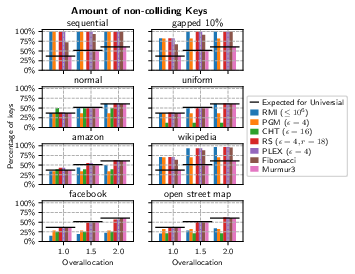

In [162]:
def plot_winners(data):
    rows = 4
    cols = 2
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.6, fig_height*rows*0.65), sharex=True, sharey=True)
    
    data = data.sort_values(by=[dataset_order, dataset_size, overallocation])
    for i, (ds, df) in enumerate(data.groupby([dataset], sort=False)):
        ax = axs[int(i / cols)][i % cols]
        ax.set_title(dataset_name(ds), pad=4)
        
        overallocs = list(set(df[overallocation]))
        overallocs.sort()
        func_cnt = len(set(df[func_name]))
        bar_width = 0.8 / func_cnt
        for j, (name, df) in enumerate(df.groupby([func_name], sort=False)):            
            for k, (overalloc, df) in enumerate(df.groupby([overallocation], sort=False)):
                ax.bar(
                    data=df, 
                    x=k - (func_cnt/2 * bar_width) + (j * bar_width) - bar_width / 2, 
                    height=normalized_winner_elems, 
                    width=bar_width, 
                    label=human_func_name(name) 
                    if k == 0 else None, 
                    color=get_color(name)
                )
                
        # draw optima
        for k, overalloc in enumerate([1.0, 1.5, 2.0]):
            optimum_y = math.e**(-1/overalloc) # from theory section
            min_x = k - (2 + func_cnt/2) * bar_width
            max_x = k + func_cnt/2 * bar_width
            # print(min_x, max_x)
            ax.plot([min_x, max_x], [optimum_y, optimum_y], label="Expected for Universial" if k == 0 else None, linestyle="-", linewidth=1, color="black")
        
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(overallocs)
        ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
        ax.grid(linestyle="--", axis="both", which="major")
        if int(i/cols) == rows-1:
            ax.set_xlabel("Overallocation")
            
    h, l = axs[0][0].get_legend_handles_labels()
    fig.legend(
        h, l,
        loc="center left",
        bbox_to_anchor=(0.9, 0.5),
        ncol=1,
        borderpad=0.4, 
        labelspacing=0.2, 
        handlelength=1.0, 
        handletextpad=0.5, 
        columnspacing=0.7
    )
    
    fig.suptitle(f"Amount of non-colliding Keys", y=0.96, fontweight="bold")
    fig.text(-0.01, 0.5, 'Percentage of keys', va='center', rotation='vertical')
    
    fig.subplots_adjust(hspace=0.4)
    fig.savefig("winners.pdf", bbox_inches="tight", dpi=300)
    fig.savefig("winners.pgf", bbox_inches="tight", dpi=300)
            
plot_winners(slots_df)